In [57]:
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import numpy as np

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import math
import cv2
import os

/Users/dimasdmm/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


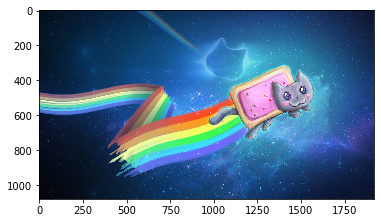

In [2]:
# Read and show image
filename = 'NyanCat1.jpg'
img = imread(filename)
img.shape

# You can see, that images are stored as 3-dimensional arrays, which
# it contains RGB description of each pixel.
fig = plt.figure()
plt.imshow(img)

# Task 1: Image clustering

We are going to use the K-Means method.

The clustering procedure outputs:
1. Cluster centroids (as pixel colors).
2. The compressed image where pixel colors are replaced with corresponding cluster centroid's color.
3. Compare the amount of memory needed to store the original and compressed image.

We need a function to initialize the centroids in some random position of the image. We have chosen $K$ pixels from the image such that they are equally spaced.

In [3]:
def init_centroids(features, K):
    step = int(len(features) / (K + 1))
    centroids = []
    for i in range(K):
        c = features[(i + 1) * step]
        centroids.append(c)
    
    return np.array(centroids)

Based on the centroid RGB values, we have to compute the closest one for every pixel in the image. To compute the closest centroid $c_c$ for a pixel $p_i$, we calculate the Euler's norm and then we pick the minimum one. This is going to result in a label $l_i \in \{0,1,...,K-1\}$

$$\text{closest}(p_i) = \min\left\{\|c - p_i\|^2\ :\ c \in C\right\} = l_i$$

In the function, note that we do not consider the first two values (i.e. the coordinates of the pixel) since they are the coordinates of the pixel. We only take the RGB values to compute the Euler's norm.

In [4]:
def get_labels(features, centroids, K):
    labels = []
    
    for f_value in features:        
        closest_centroid = centroids[0]
        centroid_i = 0
        current_d = np.linalg.norm(closest_centroid[2:5] - f_value[2:5]) ** 2

        for i in range(1, K):
            d = np.linalg.norm(centroids[i][2:5] - f_value[2:5]) ** 2
            if float(d) < float(current_d):
                current_d = d
                closest_centroid = centroids[i]
                centroid_i = i

        labels.append(int(centroid_i))
    return np.array(labels)

Now, k-means clustering technique is an iterative algorithm for partitioning objects into $k$ subsets of $C$.

We need to compute the centroid $c_i$ for every cluster $C_i$:
$$c_i = \frac{1}{|C_i|} \sum_{i \in C_i} v_i$$
where $v_i$ is a RGB vector of the image in the cluster $C_i$.

In [5]:
def centeroidnp(arr):
    partition_length = arr.shape[0]
    centroid = []
    for i in range(len(arr[0])):
        sum_x = np.sum(arr[:, i])
        centroid.append(sum_x)
    
    centroid = (np.array(centroid) / partition_length).astype(int)
    return centroid

In [6]:
def mass_centers(features, centroids, K, labels):
    mass_centers = []
    c_vectors = []

    for c_i in range(K):
        indices = (labels == c_i).nonzero()
        f_values = features[indices]
        mc = centeroidnp(f_values)
        mass_centers.append(mc)
    
    return mass_centers

We define the cost function of the algorithm as the sum of the squared distances between the objects (the vectors of the image) and their centroids:
$$J(C) = \sum^k_{j=1} \sum_{i \in C_j} d(v_i, c_j)^2$$

In [7]:
def cost_function(features, centroids, K, labels):
    cost = 0
    for c_i in range(K):
        indices = (labels == c_i).nonzero()
        f_values = features[indices]
        for f_v in f_values:
            cost += np.linalg.norm(f_v[2:5] - centroids[c_i][2:5])**2
    return cost

Based on the centroids and labels that we have computed, we generate the image based on the values of the centroid of each pixel.

In [8]:
def get_clustered_image(img, centroids, labels):
    center = np.uint8([c[2:5] for c in centroids])
    result_image = center[labels.flatten()]

    # Reshape vector with the dimensions of the original image
    result_image = result_image.reshape(img.shape)
    
    return result_image

In [63]:
# Optionally, add the list of centroids to display them
def display_clustered_image(img, clustered_img, K, centroids=[]):
    figure_size = 15
    plt.figure(figsize=(figure_size, figure_size))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(clustered_img)
    plt.title('Segmented Image when K = %d' % K)
    plt.xticks([])
    plt.yticks([])

    for c in centroids:
        ax.add_patch(Circle((c[1], c[0]), radius=25, color='red'))
    
    plt.show()

Now, let's put all together. We need to convert the $M \times N \times 3$ image into a $R \times 3$ matrix where $R = M * N$, $M$ is the height and $N$ is the width. That is, we are transforming image into a list of vectors where the first two values are the coordinates of the pixel and the other three values are the RGB values.

In [10]:
ind = np.indices(img.shape[:2]).transpose(1,2,0)
features = np.dstack((ind, img)).reshape(-1, 5)

We will compute $K$ clusters (we have chosen $K=5$) for our image. We will do up-to $25$ iterations to find the clusters.

Iteration: 1 - Cost: 9025637096


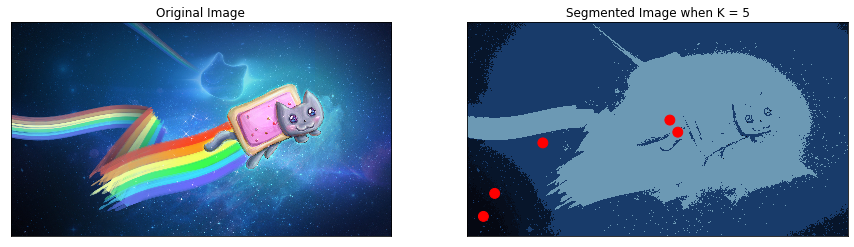

Iteration: 2 - Cost: 8166765058


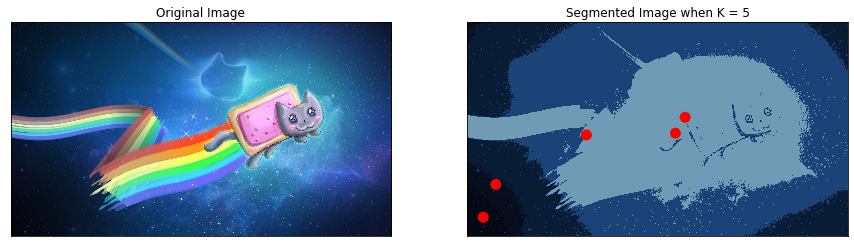

Iteration: 3 - Cost: 7776643087


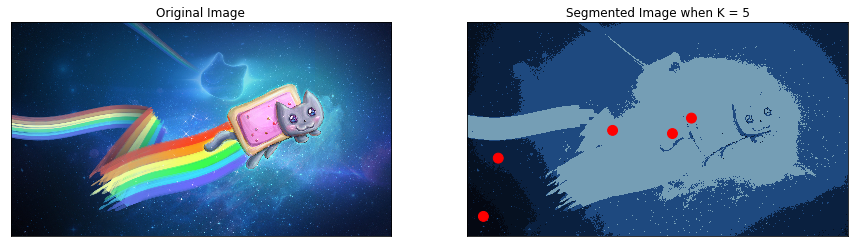

Iteration: 4 - Cost: 7462071614


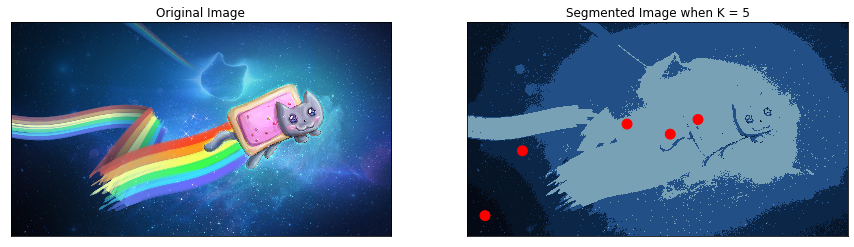

Iteration: 5 - Cost: 7169848322


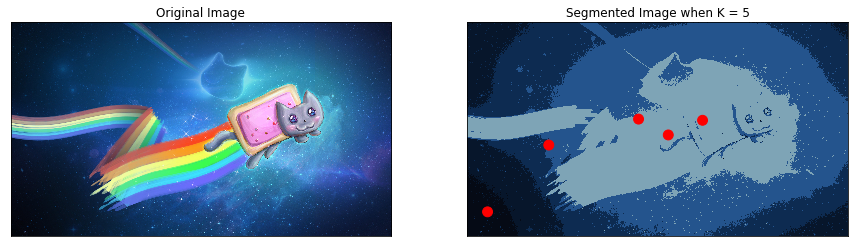

Iteration: 6 - Cost: 6894598625


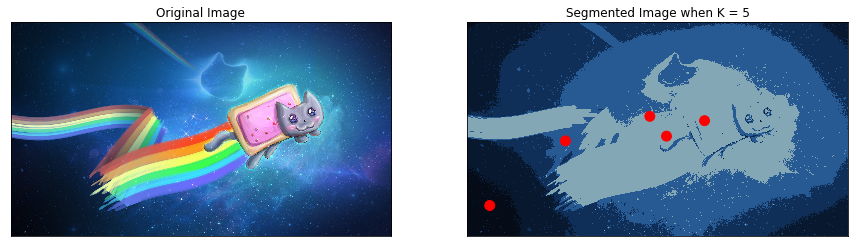

Iteration: 7 - Cost: 6622900854


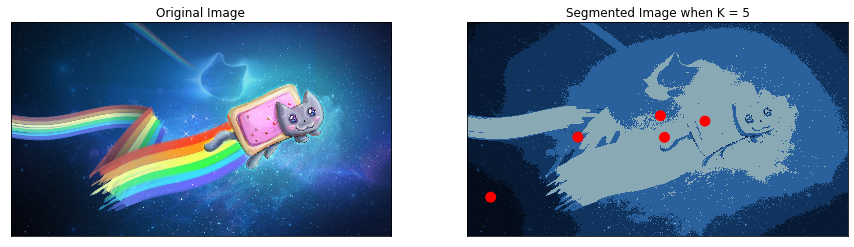

Iteration: 8 - Cost: 6327411756


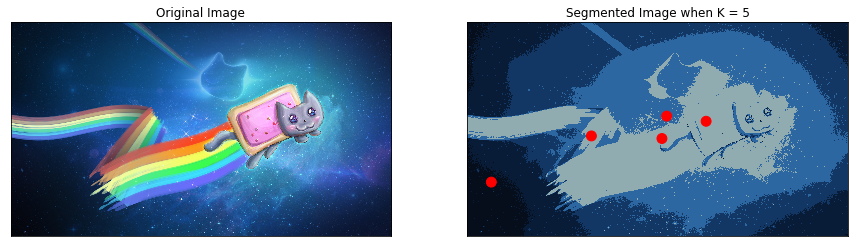

Iteration: 9 - Cost: 5976300080


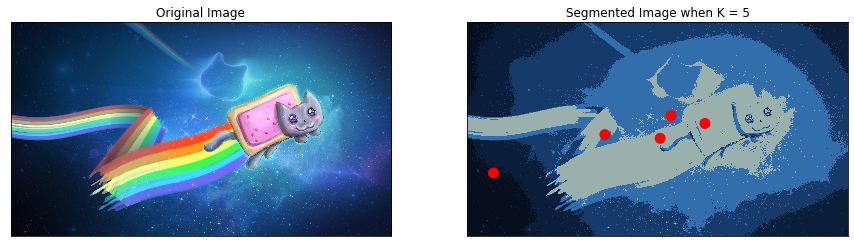

Iteration: 10 - Cost: 5529771483


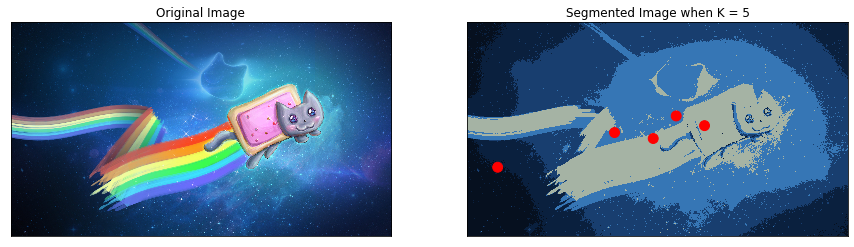

Iteration: 11 - Cost: 4918039423


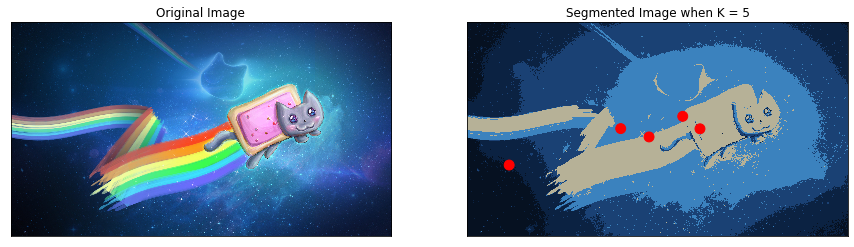

Iteration: 12 - Cost: 4523274946


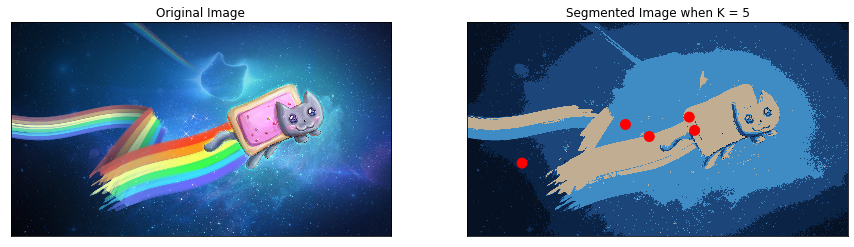

Iteration: 13 - Cost: 4265572310


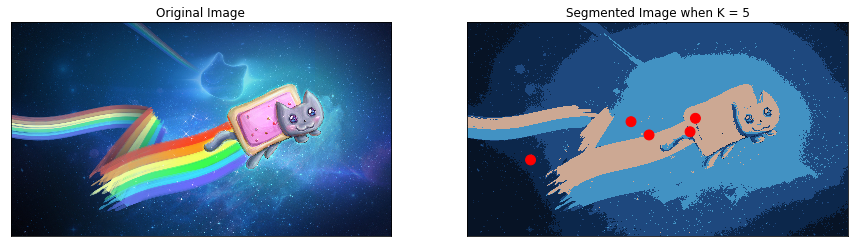

Iteration: 14 - Cost: 4159306651


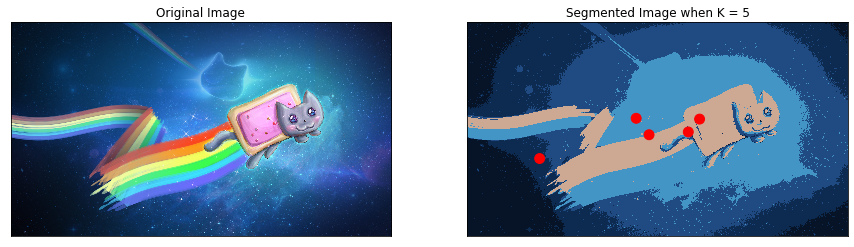

Iteration: 15 - Cost: 4087945375


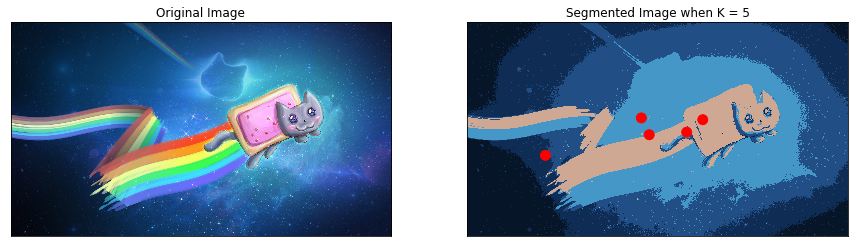

Iteration: 16 - Cost: 4033258537


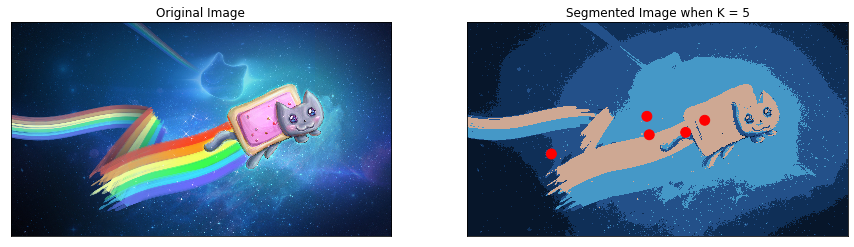

Iteration: 17 - Cost: 3991538287


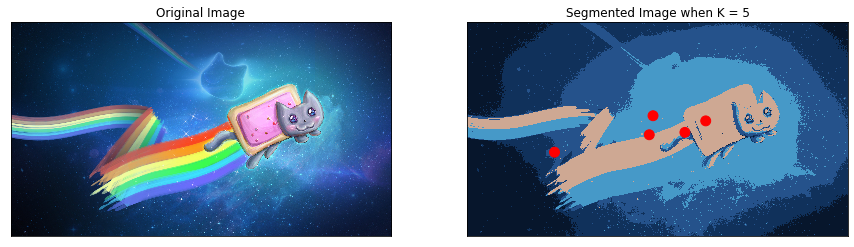

Iteration: 18 - Cost: 3958152767


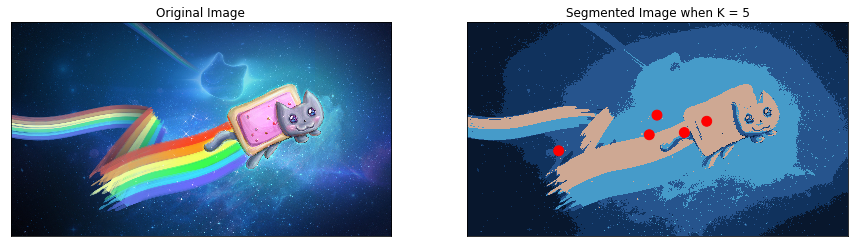

Iteration: 19 - Cost: 3935441747


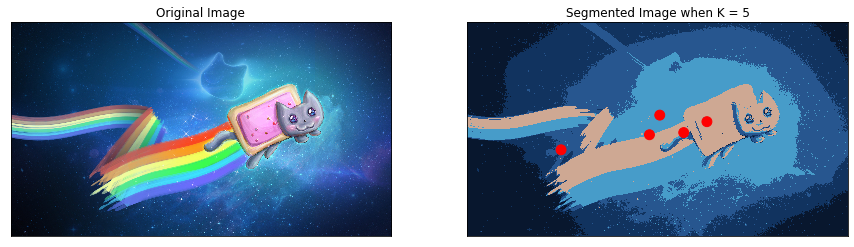

Iteration: 20 - Cost: 3916559644


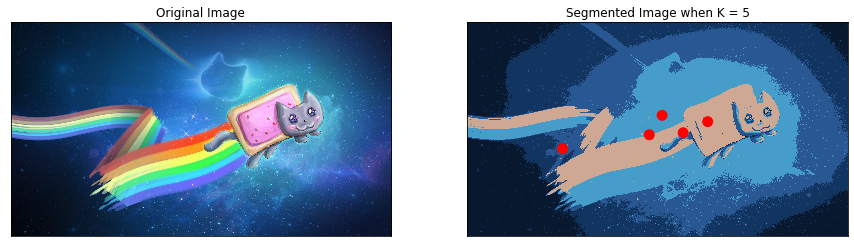

Iteration: 21 - Cost: 3901500198


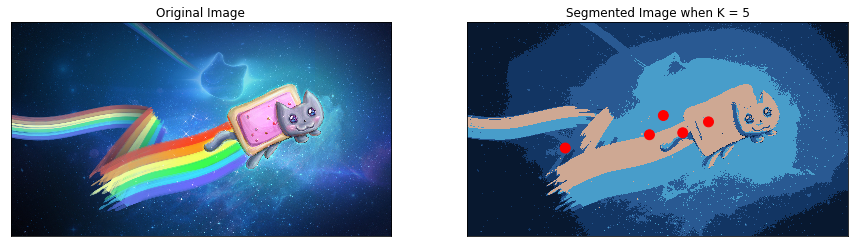

Iteration: 22 - Cost: 3889143089


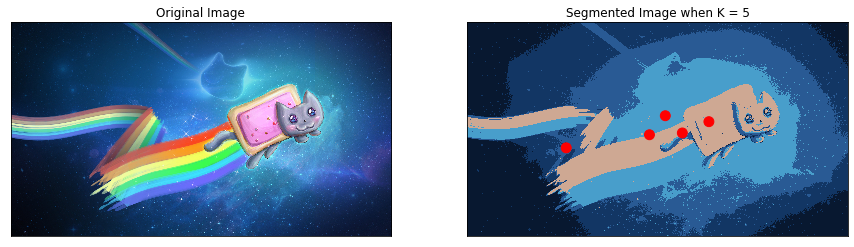

Iteration: 23 - Cost: 3879348190


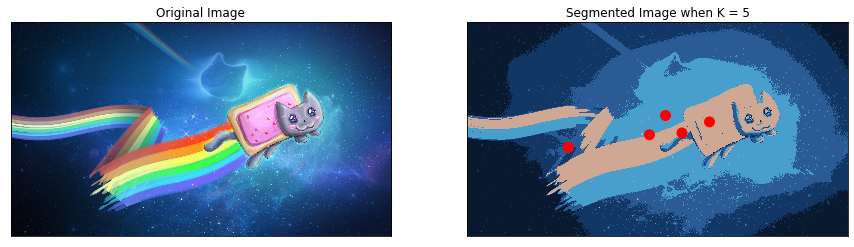

Iteration: 24 - Cost: 3871690955


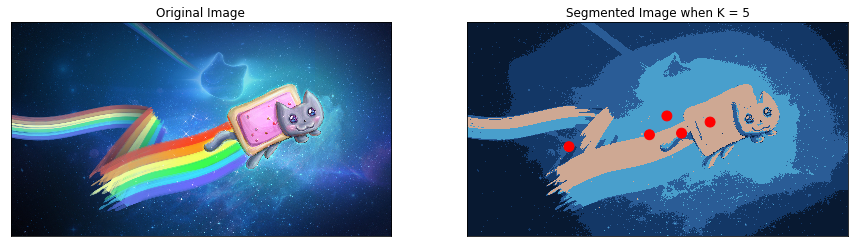

Iteration: 25 - Cost: 3865320011


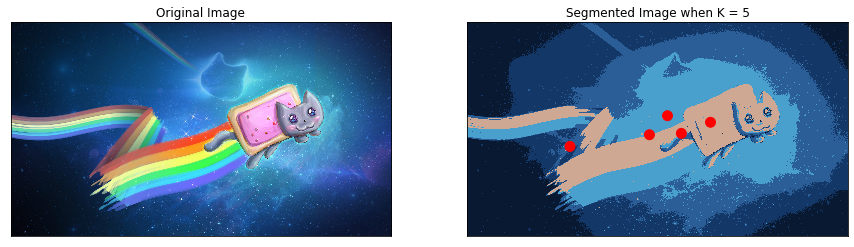

In [11]:
K = 5
n_iterations = 25

history = []
centroids = init_centroids(features, K)

cost = -1
for i in range(n_iterations):
    labels = get_labels(features, centroids, K)
    centroids = mass_centers(features, centroids, K, labels)

    prev_cost = cost
    cost = cost_function(features, centroids, K, labels)
    if cost == prev_cost:
        break
    
    history.append(cost)
    print('Iteration: %d - Cost: %d' % (i + 1, cost))
    
    clustered_img = get_clustered_image(img, centroids, labels)
    display_clustered_image(img, clustered_img, K, centroids)

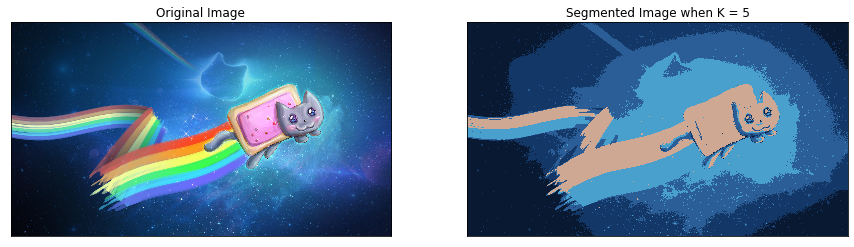

In [12]:
# Final result
clustered_img = get_clustered_image(img, centroids, labels)
display_clustered_image(img, clustered_img, K)

In [15]:
# Save and compare the amount of memory needed
clust_filename = 'clust_' + filename
cv2.imwrite(clust_filename, cv2.cvtColor(clustered_img, cv2.COLOR_RGB2BGR))

original_file_size = os.path.getsize(filename)
clustered_file_size = os.path.getsize(clust_filename)
compressed_ratio = 100 - clustered_file_size / original_file_size * 100

print('Original file size: %.2f KB' % (original_file_size / 1024))
print('Clustered file size: %.2f KB' % (clustered_file_size / 1024))
print('Compressed ratio: %.2f%%' % compressed_ratio)

Original file size: 1406.46 KB
Clustered file size: 451.07 KB
Compressed ratio: 67.93%


### Clustering with OpenCV

The library OpenCV provides `cv2.kmeans(samples, nclusters(K), criteria, attempts, flags)` function for color clustering.

- `samples`: It should be of `np.float32` data type, and each feature should be put in a single column.
- `nclusters(K)`: Number of clusters required at the end.
- `criteria`: It is the iteration termination criteria. When this criterion is satisfied, the algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:

Type of termination criteria. It has 3 flags as below:
- `cv.TERM_CRITERIA_EPS`: stop the algorithm iteration if specified accuracy, epsilon, is reached.
- `cv.TERM_CRITERIA_MAX_ITER`: stop the algorithm after the specified number of iterations, max_iter.
- `cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER`: stop the iteration when any of the above condition is met.

In [16]:
vectorized = img.reshape((-1, 3))
vectorized = np.float32(vectorized)
vectorized

Array([[ 6., 14., 27.],
       [ 7., 15., 26.],
       [ 4., 13., 22.],
       ...,
       [10., 15., 35.],
       [ 7., 14., 33.],
       [ 7., 15., 36.]], dtype=float32)

In [17]:
attempts = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

ret, labels, center = cv2.kmeans(vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [18]:
center = np.uint8(center)
clustered_img = center[labels.flatten()]

# Reshape vector with the dimensions of the original image
clustered_img = clustered_img.reshape((img.shape))

We obtain a result which is pretty much the same, but it is really faster compared to my implementation.

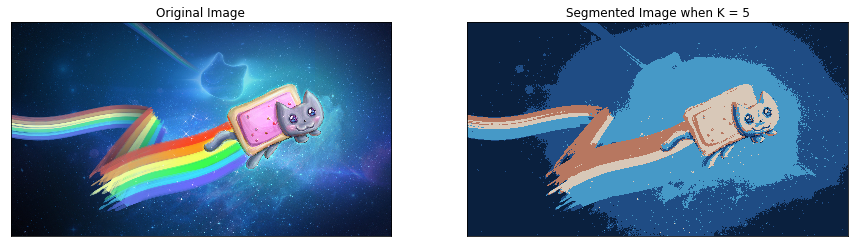

In [19]:
display_clustered_image(img, clustered_img, K)

Finally, let's compute the segmented image with different values of $K$:

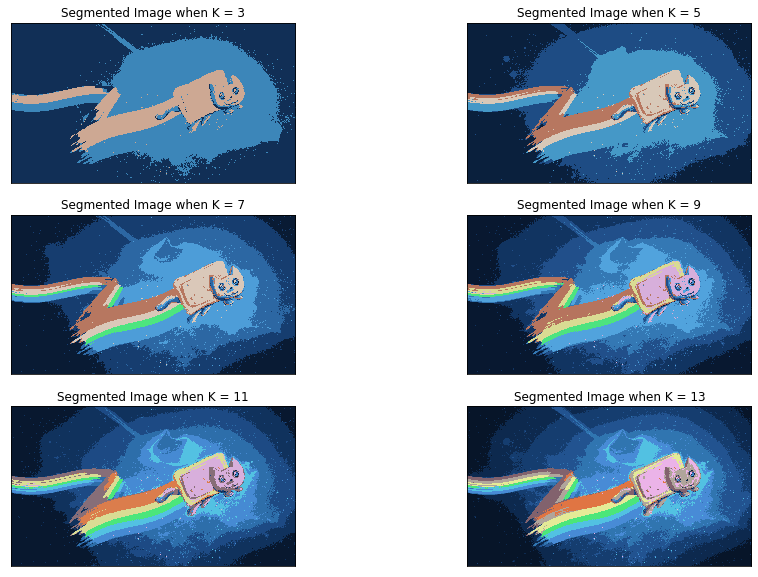

In [21]:
Ks = [3,5,7,9,11,13]
attempts = 10

index_subplot = 1
n_cols_subplot = 2
n_rows_subplot = math.ceil(len(Ks) / n_cols_subplot)
plt.figure(figsize=(15, 10))

for k in Ks:
    ret, labels, center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    clustered_img = center[labels.flatten()]
    clustered_img = clustered_img.reshape((img.shape))
    
    plt.subplot(n_rows_subplot, n_cols_subplot, index_subplot)
    plt.imshow(clustered_img)
    plt.title('Segmented Image when K = %d' % k)
    plt.xticks([])
    plt.yticks([])
    
    index_subplot += 1

# Task 2: Determine the optimal number of clusters

The *Elbow method* is one of the approaches for making decisions on the number of clusters for the K-Means method. The idea is to calculate the target function $J(R)$ for every natural number $K$ from a certain range.

The optimal number of clusters is defined as the value of $K$, starting with which the value of $J(R)$ does not decrease so sharply. For example, the number of classes defined by the below image can be chosen equal to 4.

![Figure 1](figure-1.png "Figure1")

Using the data from `elbow.txt` and the elbow method, we will define the optimal number of clusters.

We will take the decision on the choice of the number of clusters at $k′$, such that $J(Ck′+1)$ drops "*not so fast*":

$$D(k) = \frac{| J(C_k) - J(C_{k+1}) |}{| J(C_{k-1}) - J(C_k) |}$$

In [31]:
def convert_str_to_float(s): 
    return s.strip().replace(',', '.')

In [32]:
with open('elbow.txt') as fp:
    data = np.loadtxt([convert_str_to_float(x) for x in fp], delimiter='\t')

[-2.74771081  3.57568039]


In [53]:
# The idea is to find the optimal K value in the range [4,16]
K_init = 4
K_end = 16

sse = {}
for k in range(K_init, K_end + 1):
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit(data)
    sse[k] = clusters.inertia_

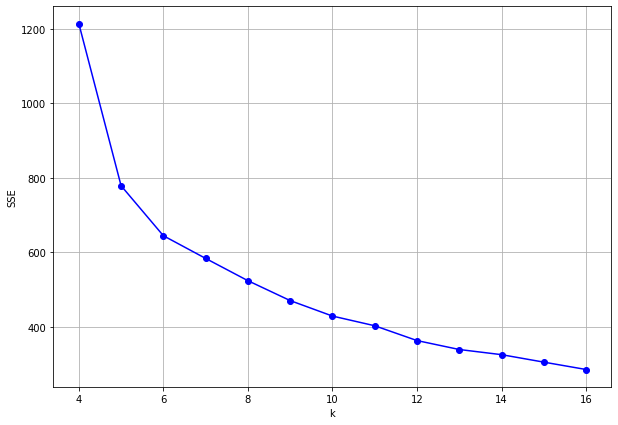

In [54]:
plt.figure(figsize=(10,7))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', color='b')
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid()
plt.show()

We are going to use the library `yellowbrick` which already implements the _Elbow method_. By default, the scoring parameter metric is set to `distortion`, which computes the sum of squared distances from each point to its assigned center. See: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

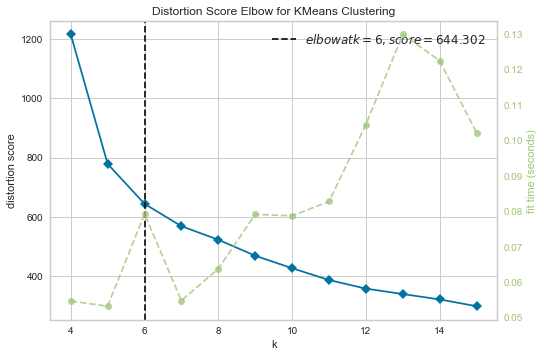

In [58]:
visualizer = KElbowVisualizer(KMeans(), k=(K_init, K_end))
visualizer.fit(data)
visualizer.show()

### Re-make task 1

Now, let's use the previous code to compute the optimal $K$ value in the first task.

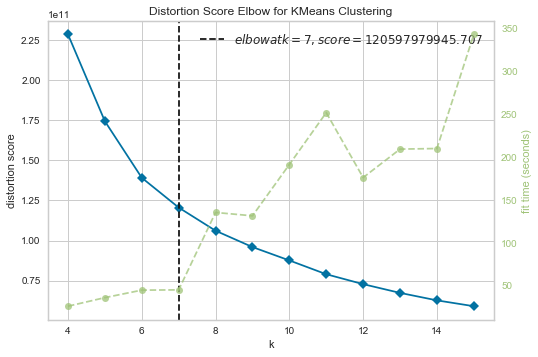

In [59]:
visualizer = KElbowVisualizer(KMeans(), k=(K_init, K_end))
visualizer.fit(features)
visualizer.show()

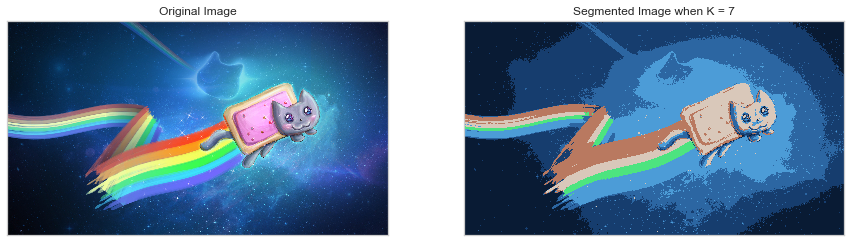

In [64]:
# Writing again the code of the task 1 (where we use the library OpenCV)
K_optimal = 7

vectorized = img.reshape((-1, 3))
vectorized = np.float32(vectorized)

attempts = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, labels, center = cv2.kmeans(vectorized, K_optimal, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
clustered_img = center[labels.flatten()]
clustered_img = clustered_img.reshape((img.shape))

display_clustered_image(img, clustered_img, K_optimal)

In [65]:
# Save and compare the amount of memory needed
clust_filename = 'optimal_clust_' + filename
cv2.imwrite(clust_filename, cv2.cvtColor(clustered_img, cv2.COLOR_RGB2BGR))

original_file_size = os.path.getsize(filename)
clustered_file_size = os.path.getsize(clust_filename)
compressed_ratio = 100 - clustered_file_size / original_file_size * 100

print('Original file size: %.2f KB' % (original_file_size / 1024))
print('Clustered file size: %.2f KB' % (clustered_file_size / 1024))
print('Compressed ratio: %.2f%%' % compressed_ratio)

Original file size: 1406.46 KB
Clustered file size: 485.61 KB
Compressed ratio: 65.47%
